In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# Read training and testing data
training_data = pd.read_csv('/kaggle/input/titanic/train.csv')
testing_data = pd.read_csv('/kaggle/input/titanic/test.csv')
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Summarize data
print(training_data['Pclass'].value_counts(dropna=False))
print()
print(training_data['Sex'].value_counts(dropna=False))
print()
print(training_data['Age'].isna().sum())
print(training_data['Age'].describe())
print()
print(training_data['SibSp'].value_counts(dropna=False))
print()
print(training_data['Parch'].value_counts(dropna=False))
print()
print(training_data['Fare'].isna().sum())
print(training_data['Fare'].describe())
print()
print(training_data['Cabin'].value_counts(dropna=False))
print()
print(training_data['Embarked'].value_counts(dropna=False))
print()
print(training_data['Survived'].value_counts(dropna=False))

3    491
1    216
2    184
Name: Pclass, dtype: int64

male      577
female    314
Name: Sex, dtype: int64

177
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

0
count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

NaN            687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

0    549

In [4]:
def transform_data(df, category_transformers, is_training):

    age_male_series = df.loc[df['Sex'] == 'male', ['Age']]
    df.loc[df['Sex'] == 'male', ['Age']] = df.loc[df['Sex'] == 'male', ['Age']].fillna(value=age_male_series.mean())
    age_female_series = df.loc[df['Sex'] == 'female', ['Age']]
    df.loc[df['Sex'] == 'female', ['Age']] = df.loc[df['Sex'] == 'female', ['Age']].fillna(value=age_female_series.mean())
    df['LastName'] = df.apply(lambda x: x.Name.split(',')[0], axis=1)
    df[['Cabin', 'Embarked']] = df[['Cabin', 'Embarked']].fillna(value='U')
    df['CabinLetter'] = df.apply(lambda x: x['Cabin'][0], axis=1)
    df = df.drop(['Name','Ticket','Cabin','PassengerId'], axis=1)
    df['Fare'] = df['Fare'].fillna(value=df['Fare'].mean())

    if is_training:
        df = category_transformers[0].fit_transform(df)
        df = category_transformers[1].fit_transform(df)
    else:
        df = category_transformers[0].transform(df)
        df = category_transformers[1].transform(df)
    return df

In [5]:
category_transformers = [ce.OneHotEncoder(cols=['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'CabinLetter'], handle_missing='value'), ce.BinaryEncoder(cols=['LastName'], handle_missing='value')]
training_data_X, training_data_Y = training_data.drop('Survived', axis=1), training_data['Survived']
testing_data_X = testing_data
training_data_X = transform_data(training_data_X, category_transformers, is_training=True)
testing_data_X = transform_data(testing_data_X, category_transformers, is_training=False)

In [6]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(training_data_X, training_data_Y)

RandomForestClassifier()

In [7]:
predictions = rf_classifier.predict(testing_data_X)

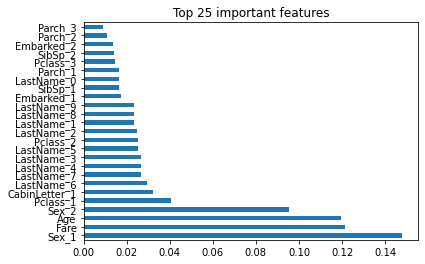

In [8]:
feat_importances = pd.Series(rf_classifier.feature_importances_, index=training_data_X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.title("Top 25 important features")
plt.show()

In [9]:
final_output = pd.DataFrame()
final_output['PassengerId'] = testing_data['PassengerId']
final_output['Survived'] = predictions

In [10]:
final_output.to_csv('/kaggle/working/submission.csv', index=False)